In [1]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

astropy module not found


In [2]:
def get_thickness(bin_sample, mask_sample, pixel_size):
    # get the local thickness
    local_thickness = lt.local_thickness(bin_sample, mask=mask_sample)
    thickness_true = 2*local_thickness
    # we want it in real world units
    thickness_true *= pixel_size

    return thickness_true

def get_statistics(bin_sample, mask_sample, pixel_size):
    # get ratio
    ratio = np.sum(bin_sample)/np.sum(mask_sample)

    # get the local thickness
    thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
    thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

    # get the mean thickness
    mean_thickness_stone = np.mean(thickness_stone[thickness_stone > 0])
    mean_thickness_bubbles = np.mean(thickness_bubbles[thickness_bubbles > 0])

    # get median thickness
    median_thickness_stone = np.median(thickness_stone[thickness_stone > 0])
    median_thickness_bubbles = np.median(thickness_bubbles[thickness_bubbles > 0])
    
    return [ratio, mean_thickness_stone, mean_thickness_bubbles, median_thickness_stone, median_thickness_bubbles]


def extract_samples(mask, pixels_per_mm, mm_per_grid=5, discard_threshold=0.5):
    """
    Extracts a grid of samples from a mask where each sample has a meaningful amount of data.

    Args:
        mask: A 3D numpy array representing the mask.
        pxels_per_mm: The number of pixels per mm in the volume.
        mm_per_grid: The physical size of each grid element.
        discard_threshold: The threshold for discarding samples based on the mask.

    Returns:
        A list of dicts that map the indices of the extracted samples
    """
    samples = []
    for i in range(0, mask.shape[0], int(mm_per_grid * pixels_per_mm)):
        for j in range(0, mask.shape[1], int(mm_per_grid * pixels_per_mm)):
            for k in range(0, mask.shape[2], int(mm_per_grid * pixels_per_mm)):
                if np.mean(mask[i:i + int(mm_per_grid * pixels_per_mm), j:j + int(mm_per_grid * pixels_per_mm), k:k + int(mm_per_grid * pixels_per_mm)]) > discard_threshold:
                    samples.append({'i': (i, i + int(mm_per_grid * pixels_per_mm)),
                                    'j': (j, j + int(mm_per_grid * pixels_per_mm)),
                                    'k': (k, k + int(mm_per_grid * pixels_per_mm))})
    return samples

def apply_grid(volume, grid_dict):
    """
    Extracts a sliced volume based on the grid_dict.
    
    volume: A 3D numpy array representing the volume.
    grid_dict: A dict containing the indices of the volume to extract as given in extract_samples
    
    """
    i, i_mark = grid_dict['i']
    j, j_mark = grid_dict['j']
    k, k_mark = grid_dict['k']

    return volume[i:i_mark, j:j_mark, k:k_mark]
    

In [3]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/Lava_data/Island_ny/'
file_name = 'lavasten_Island_ny_LFOV-80kV-LE2-1.8s-21.8micro_recon.txm'
absolute_path = os.path.join(folder_path, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

In [4]:
print(all_data[1].keys())
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(pixel_size)
img_shape = data.shape
print(img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print(pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
21.822635650634766
(1018, 1024, 1004)
[22.21544309 22.34637891 21.90992619]
45.823979101759534


In [5]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project/results'
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
bin_data = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, file_name)
mask = tifffile.imread(absolute_path)

In [21]:

grid_list = extract_samples(mask=mask,
                               pixels_per_mm=pixels_per_mm,
                               mm_per_grid=5,
                               discard_threshold=0.33)


grid_dict = grid_list[10]
bin_sample = apply_grid(volume=bin_data, grid_dict=grid_dict)
mask_sample = apply_grid(volume=mask, grid_dict=grid_dict)


In [20]:
print(len(grid_list))

21


In [22]:
statistics = []
for i, grid_dict in enumerate(grid_list):
    print(f'Processing sample {i}/{len(grid_list)}')
    bin_sample = apply_grid(volume=bin_data, grid_dict=grid_dict)
    mask_sample = apply_grid(volume=mask, grid_dict=grid_dict)
    stats = get_statistics(bin_sample, mask_sample, pixel_size_mm)
    statistics.append(stats)

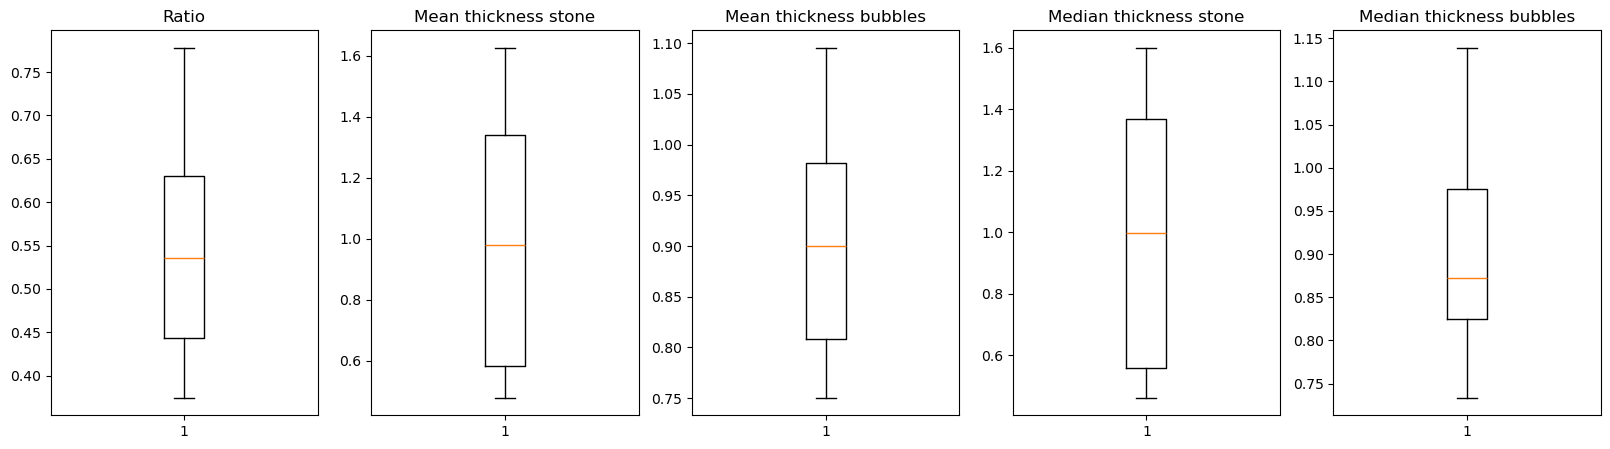

In [23]:
# make boxplots
num_stats = len(statistics[0])
fig, ax = plt.subplots(1, num_stats, figsize=(20, 5))
for i in range(num_stats):
    ax[i].boxplot([stat[i] for stat in statistics])
    ax[i].set_title(['Ratio', 'Mean thickness stone', 'Mean thickness bubbles', 'Median thickness stone', 'Median thickness bubbles'][i])

In [16]:
ratio, mean_thickness_stone, mean_thickness_bubbles, median_thickness_stone, median_thickness_bubbles = get_statistics(bin_sample, mask_sample, pixel_size)

print(f'ratio: {ratio}')
print(f'mean thickness stone: {mean_thickness_stone}')
print(f'mean thickness bubbles: {mean_thickness_bubbles}')
print(f'median thickness stone: {median_thickness_stone}')
print(f'median thickness bubbles: {median_thickness_bubbles}')


ratio: 0.6105089421794674
mean thickness stone: 1455.5950927734375
mean thickness bubbles: 1091.6904296875
median thickness stone: 1536.833740234375
median thickness bubbles: 1049.0902099609375


In [17]:
thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

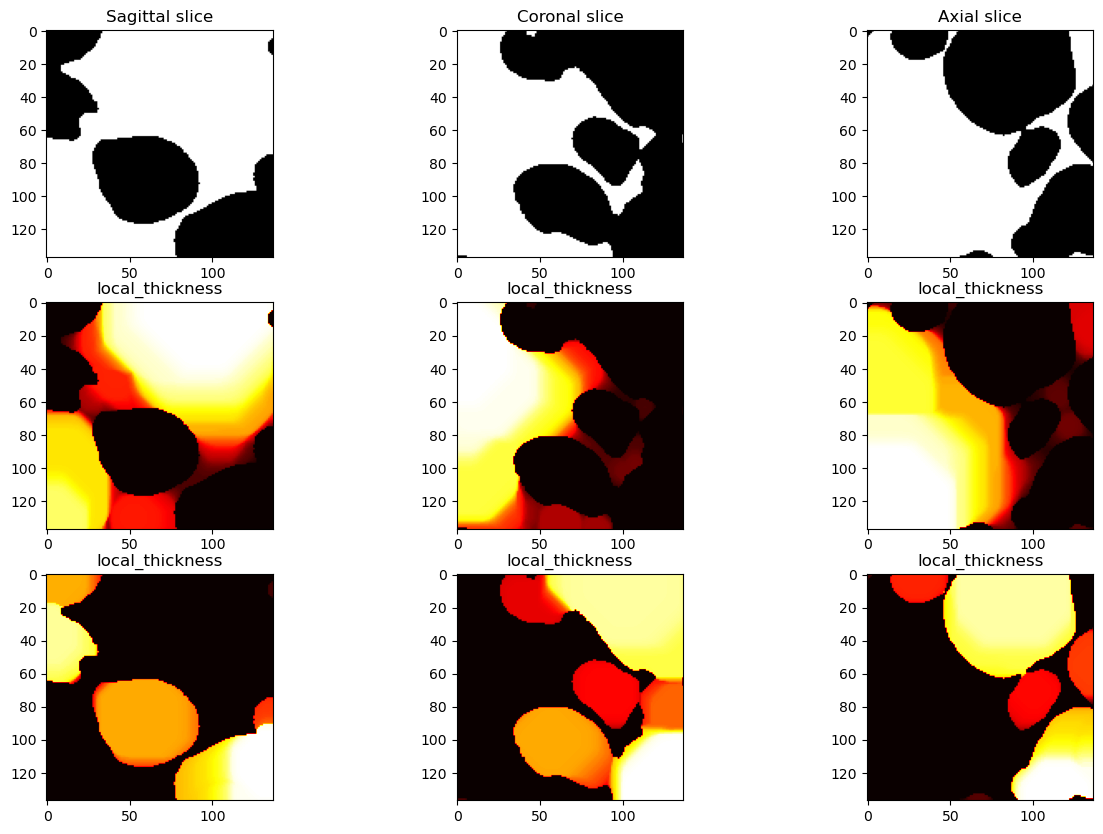

In [18]:
slice_n = 100

#----------------Sagittal slice----------------
fig, ax = plt.subplots(3,3,figsize=(15,10))
ax[0][0].imshow(np.squeeze(bin_sample[slice_n,:,:]), cmap='gray')
ax[0][0].set_title('Sagittal slice')

ax[1][0].imshow(np.squeeze(thickness_stone[slice_n,:,:]), cmap='hot')
ax[1][0].set_title('local_thickness')

ax[2][0].imshow(np.squeeze(thickness_bubbles[slice_n,:,:]), cmap='hot')
ax[2][0].set_title('local_thickness')


#----------------Coronal view----------------

ax[0][1].imshow(np.squeeze(bin_sample[:,slice_n,:]), cmap='gray')
ax[0][1].set_title('Coronal slice')

ax[1][1].imshow(np.squeeze(thickness_stone[:,slice_n,:]), cmap='hot')
ax[1][1].set_title('local_thickness')

ax[2][1].imshow(np.squeeze(thickness_bubbles[:,slice_n,:]), cmap='hot')
ax[2][1].set_title('local_thickness')


#----------------Axial view----------------

ax[0][2].imshow(np.squeeze(bin_sample[:,:,slice_n]), cmap='gray')
ax[0][2].set_title('Axial slice')

ax[1][2].imshow(np.squeeze(thickness_stone[:,:,slice_n]), cmap='hot')
ax[1][2].set_title('local_thickness')

ax[2][2].imshow(np.squeeze(thickness_bubbles[:,:,slice_n]), cmap='hot')
ax[2][2].set_title('local_thickness')

plt.show()